In [6]:
# data processing
import numpy as np
import os
import sys
import pandas as pd
import pickle

# Machine learning library
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, roc_curve, auc

# data visualizations
import matplotlib.pyplot as plt
import seaborn as sns

from svm_utils import *
from data_configuration import *


In [7]:
# Get unprocessed data
dataset = getCSVData(Location.health_data_raw)
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


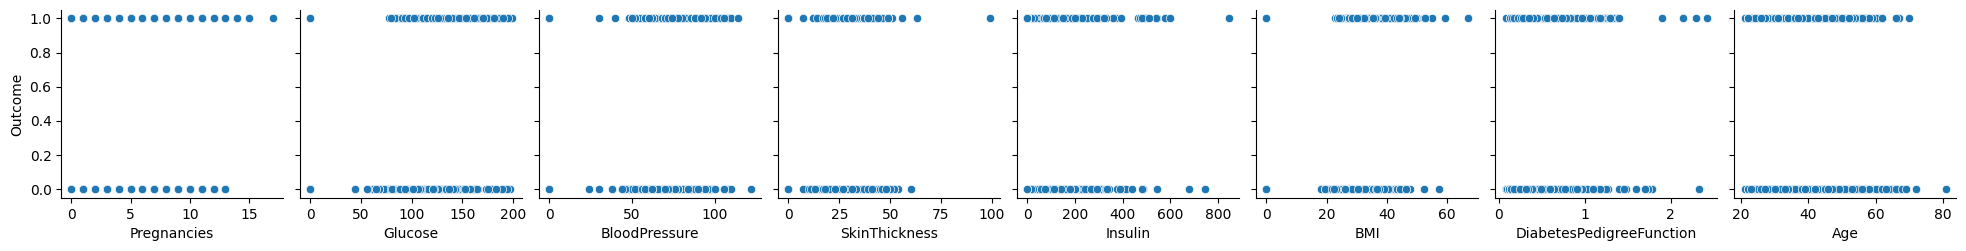

In [9]:
data_cols = [col_name for col_name in dataset.columns if col_name != ProcessConfig.health_label]
sns.pairplot(data=dataset, y_vars=[ProcessConfig.health_label], x_vars=data_cols)

<Axes: >

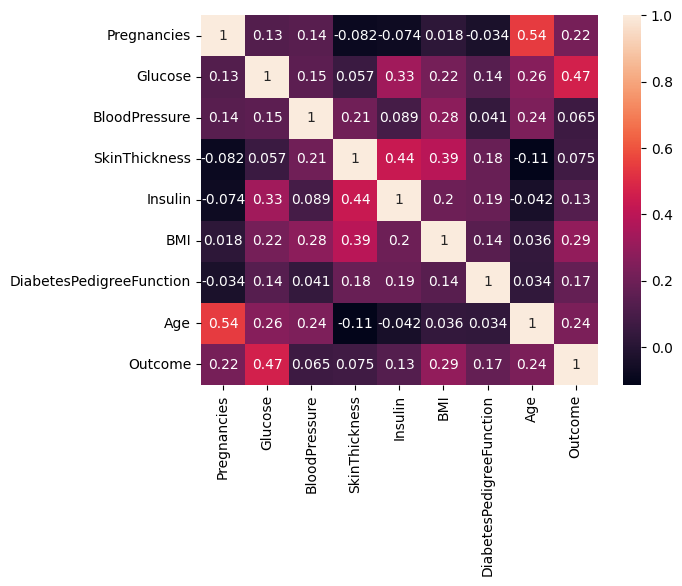

In [10]:
sns.heatmap(dataset.corr(), annot=True)

In [ ]:
# get the data
X_train, X_test, Y_train, Y_test = getProcessedData(Location.health_data_process)


In [ ]:
# Standardize features. Require for Machine learning
sc = StandardScaler()
# Fit to data, then transform it
X_train = sc.fit_transform(X_train)
sc.mean_


In [ ]:
sc.scale_

In [ ]:
# Perform standardization by centering and scaling
X_test = sc.transform(X_test)
X_test

In [ ]:
# Init an H2O cluster
h2o.init()

In [ ]:
# Convert training data to H2OFrame
# the train result will be used to train a machine learning model
train = h2o.H2OFrame(np.concatenate((X_train, Y_train.values.reshape(-1, 1)), axis=1))
train.columns = list(dataset.columns)
train[ProcessConfig.health_label] = train[ProcessConfig.health_label].asfactor()

# Specify target variable and predictor variables
x = train.columns[:-1]
y = train.columns[-1]


In [ ]:
# Run H2O AutoML to automatically select, train and optimize SVM model
aml = H2OAutoML(max_models=10, sort_metric='mse', max_runtime_secs=5 * 60, seed=666)
aml.train(x=x, y=y, training_frame=train)

In [ ]:
# View the leaderboard of trained models
lb = aml.leaderboard
print(lb.head())

In [ ]:
# Use the best model to predict on test data
model = aml.leader
X_h2o = h2o.H2OFrame(X_test)
X_h2o.columns = list(dataset.columns)[:-1]
y_pred = model.predict(X_h2o).as_data_frame().values.flatten()

In [ ]:
# Train a PySVM SVM model
model = LinearSVC(random_state=0, tol=1e-5, max_iter=10000, dual=False)
Y_pred = model.fit(X_train, Y_train)

In [ ]:
# Test the model on the test data
y_pred = model.predict(X_test)
misclassified = np.where(Y_test != y_pred)[0]
print("Indices of potentially misclassified instances: ", misclassified)

In [ ]:
# Confusion matrix - summarizing the performance of a classification algorithm.
cm = confusion_matrix(Y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
plt.tight_layout()
plt.show()

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()